In [285]:
import matplotlib.pyplot as plt
from IPython.display import display, Image

# 1. GC content

In [274]:
def perseqGCcontent(path_to_fastq, min_base_quality=0, max_N_percent=100):
    """
    Calculates GC content for each read in .fastq file.
    Optionaly skips positions with low quality (i.e. < min_base_qualiy) 
    and reads with numerous Ns (> max_N_count).
    """
    max_N_percent /= 100
    
    with open(path_to_fastq, 'r') as f:
        GCcont = []
        read_id, seq, strand, quality = [f.readline().strip() for _ in range(4)]
        
        # determine encoding
        if min(ord(q) - 64 for q in quality[:-1]) < 2:  
            phred = 33  # Sanger
        else: 
            phred = 64  # Illumina 1.5
        
        while read_id:
            AT = 0
            GC = 0
            N = 0

            for i, base in enumerate(seq):
                # skip low quality read
                if ord(quality[i]) - phred < min_base_quality:
                    continue  
                    
                if base == 'A' or base == 'T':
                    AT += 1
                elif base == 'G' or base == 'C':
                    GC += 1
                elif base == 'N':
                    N += 1
                else:
                    # check for valid format
                    raise ValueError(f'Invalid nucleotide "{base}" in position {i+1}')
                    
            # skip sequence with lots N
            if N / (i + 1) > max_N_percent:
                pass
            else:
                if GC + AT + N > 0:
                    GCcont.append(round(100 * GC /(GC + AT + N)))
                
            read_id, seq, strand, quality = [f.readline().strip() for _ in range(4)]  

    return GCcont        

In [275]:
data = './HW1_data/'
paths = ['test.fastq',  'test3.fastq', 'frag.R1.fastq', 'frag.R2.fastq']
GCconts = [perseqGCcontent(data + path) for path in paths]

Calculate frequencies & mean values:

In [276]:
from collections import Counter

mean_gc = []
frequencies = []

for gc in GCconts:
    mean_gc.append(round(sum(gc) / len(gc), 2))
    
    res = [0] * 100
    c = Counter(gc)
    for i in range(1, 101):
        if i in c.keys():
            res[i-1] = c[i]
            
    frequencies.append(res)

### Plots

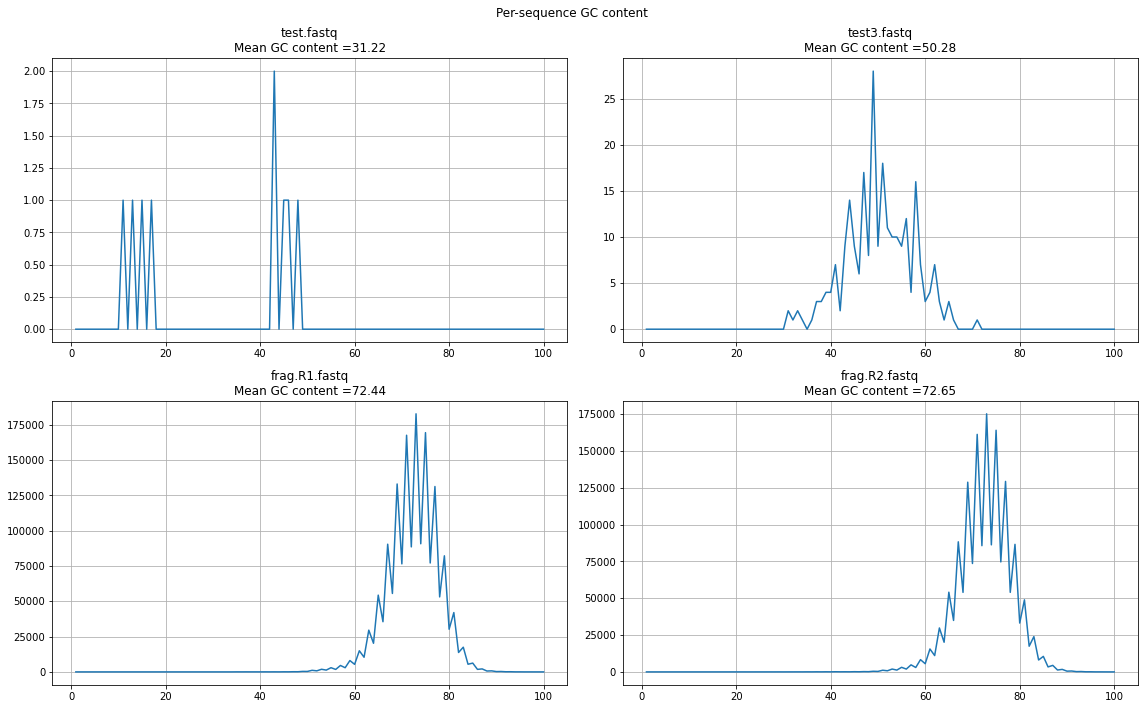

In [284]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

for i, ax in enumerate(axs.reshape(-1)):
    ax.plot(range(1, len(frequencies[i]) + 1), frequencies[i])
    ax.grid()
    ax.set_title(paths[i] + f'\nMean GC content ={mean_gc[i]}')

fig.suptitle('Per-sequence GC content')
fig.tight_layout()

### FastQC results

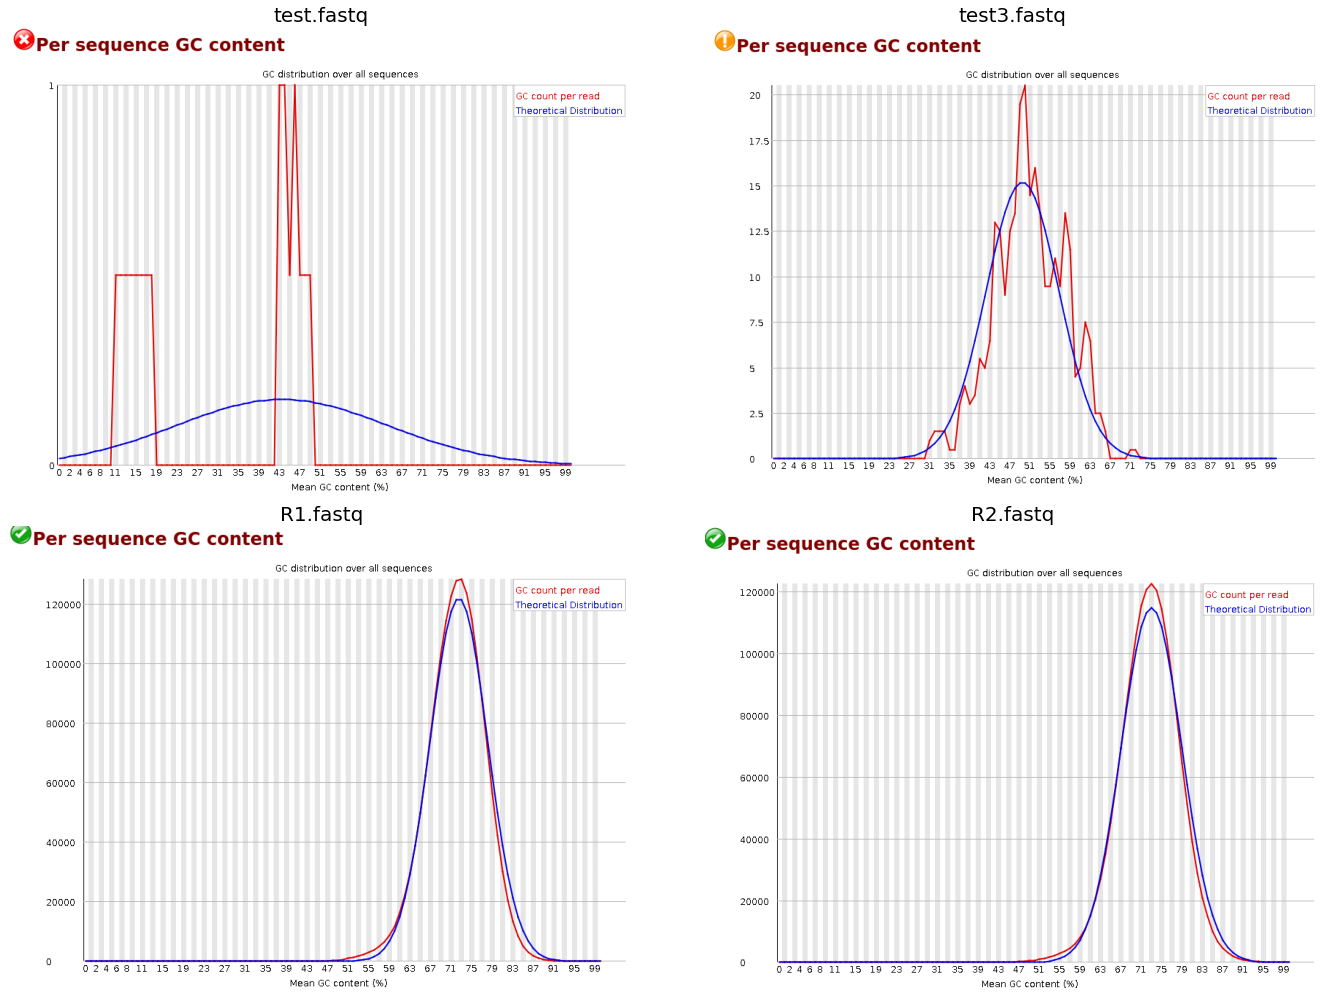

In [305]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
 
# read images
images = []
names = ['test', 'test3', 'R1', 'R2']
for i, name in enumerate(names):
    images.append(mpimg.imread(data + nambe + '_perseqGC.png'))

# display images
fig, axs = plt.subplots(2, 2, figsize=(20, 14))
for i, ax in enumerate(axs.reshape(-1)):
    ax.imshow(images[i])
    ax.set_title(names[i] + '.fastq', fontsize=20)
    ax.axis('off')
fig.tight_layout()

Форма приблизительно совпадает, за исключением того, что мои варианты получились более зигзагообразные - нечётные частоты встречаются чаще, чем чётные (полагаю, из-за особенностей округления, решение найти пока не удалось...).

Для первого графика (test.fastq) форма сопадает, если в знаменателе считать нуклеотиды N. Но не совпадает показатель meanGC. Если же N не считать, то будет совпадать meanGC, однако график сильно съедет вправо...

# 2. Per-base error probability distrtibution

Pred score $Q$ in defined by $Q = -10 \log_{10} P$, where $P$ is base-calling error probability, i.e $P = 10^{-Q / 10}$.

In [277]:
def perbase_errorprob(path_to_fastq):
    """
    Calculates error probability for each position in read.
    """
    
    with open(path_to_fastq, 'r') as f:
        read_id, seq, strand, quality = [f.readline().strip() for _ in range(4)]
        
        # determine encoding
        if min(ord(q) - 64 for q in quality[:-1]) < 2:  
            phred = 33  # Sanger
            # print(path_to_fastq, 'Sanger')
        else: 
            phred = 64  # Illumina 1.5
            # print(path_to_fastq, 'Illumina 1.5')
        
        # 1000 should be enough fot short reads
        max_read_length = 1000
        probs = [0] * max_read_length  # cumulative sum of error probability for i-th position
        counts = [0] * max_read_length  # total base count for i-th position 
                                        # (to account for different read lengths)

        max_read_length = 0  # keep actual max read length
        while read_id:
            for i, q in enumerate(quality):
                # print(ord(q), phred)
                Q = ord(q) - phred
                P = 10 ** (-Q / 10)
                probs[i] += P
                counts[i] += 1
            else:
                if i + 1 > max_read_length:
                    max_read_length = i + 1
            read_id, seq, strand, quality = [f.readline().strip() for _ in range(4)]  
            
    res = [0] * max_read_length    
    for i in range(max_read_length):
        res[i] = probs[i] / counts[i]
            
    return res 

In [282]:
data = './HW1_data/'
paths = ['test.fastq',  'test3.fastq', 'frag.R1.fastq', 'frag.R2.fastq']
error_probs = [perbase_errorprob(data + path) for path in paths]

### Plots

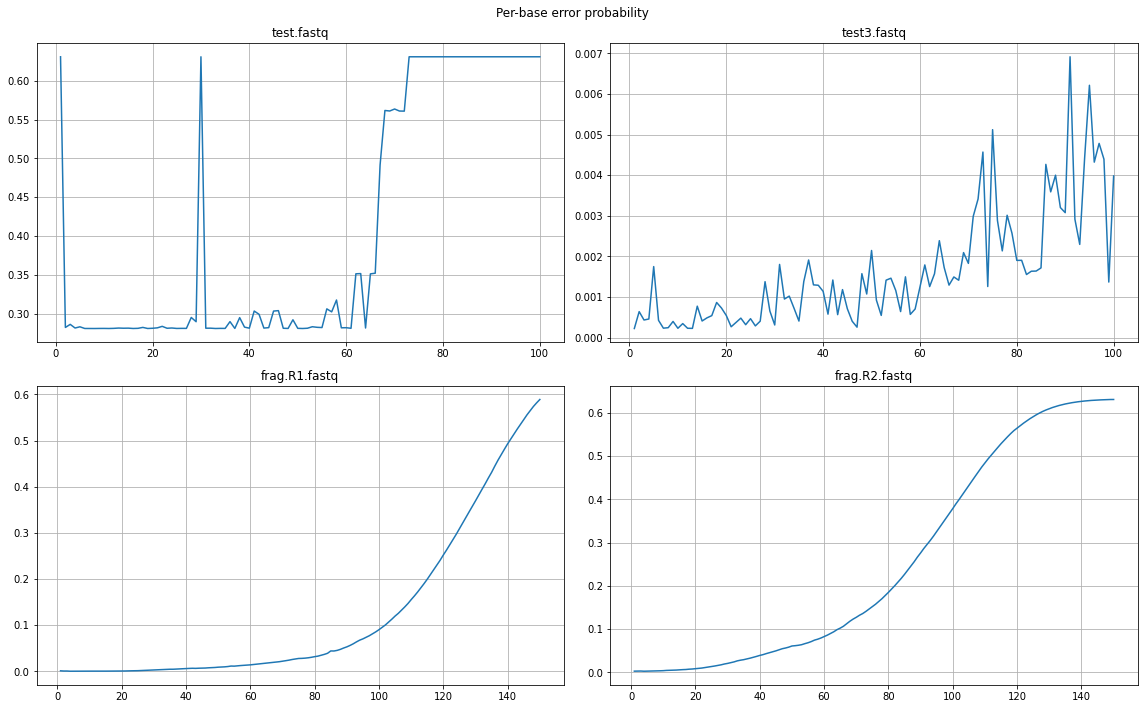

In [283]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

for i, ax in enumerate(axs.reshape(-1)):
    ax.plot(range(1, len(error_probs[i]) + 1), error_probs[i])
    ax.grid()
    ax.set_title(paths[i])

fig.suptitle('Per-base error probability')
fig.tight_layout()

### FastQC results

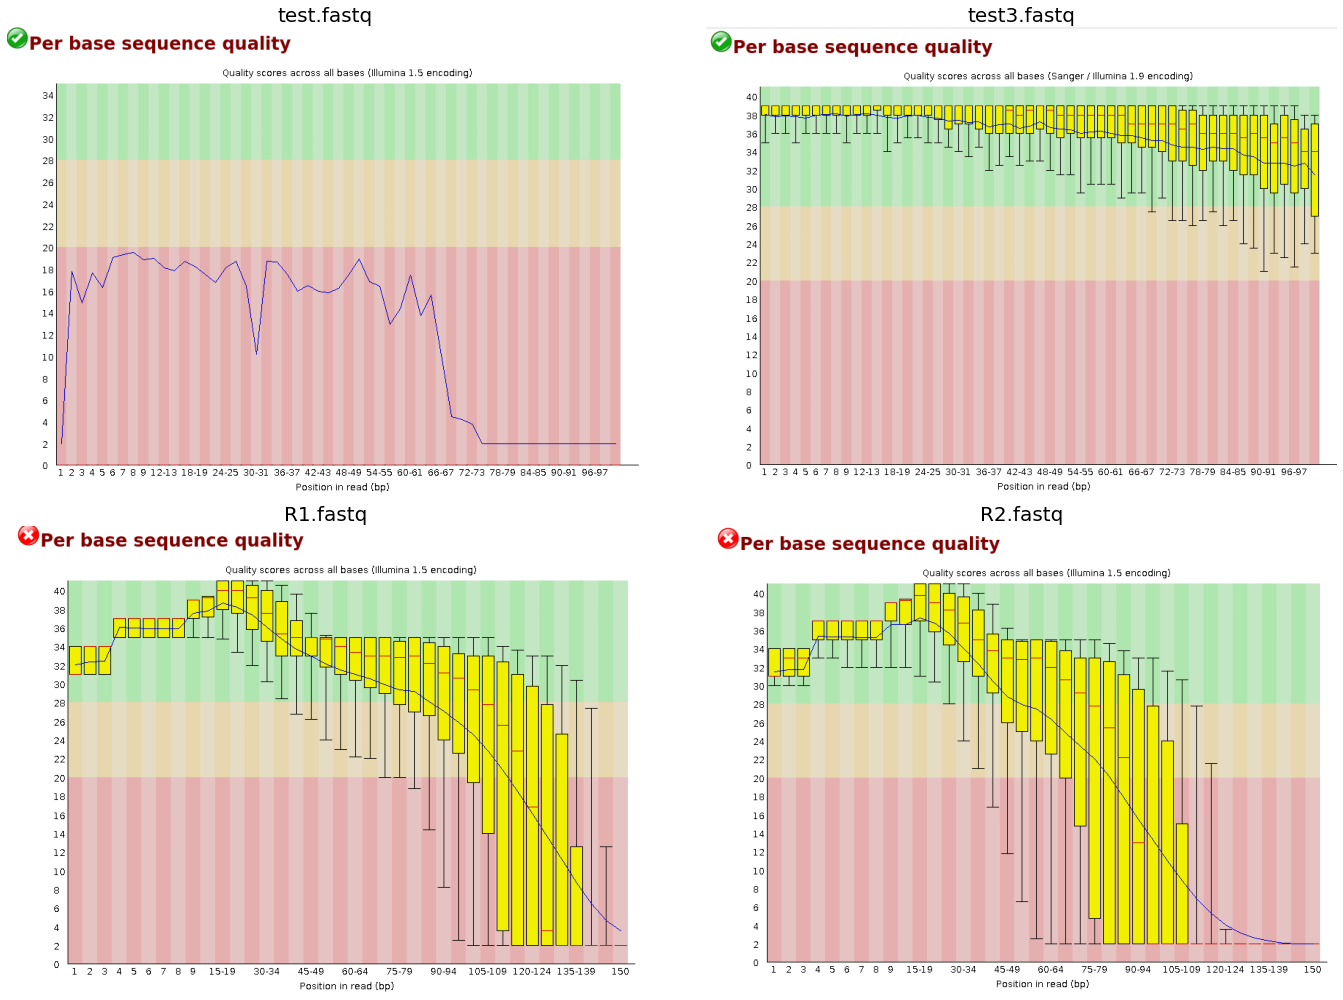

In [306]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
 
# read images
images = []
names = ['test', 'test3', 'R1', 'R2']
for i, name in enumerate(names):
    images.append(mpimg.imread(data + name + '_perbaseQ.png'))

# display images
fig, axs = plt.subplots(2, 2, figsize=(20, 14))
for i, ax in enumerate(axs.reshape(-1)):
    ax.imshow(images[i])
    ax.set_title(names[i] + '.fastq', fontsize=20)
    ax.axis('off')
fig.tight_layout()

В этом задании всё вроде сходится - тренд вероятности ошибки соответствует трендам в Per base sequence quality. 